In [564]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neural_network import MLPClassifier
import sklearn

In [565]:
#Import the transactions from the credit card CSV file as a database 
trans_df = pd.read_csv('creditcard.csv')

In [566]:
trans_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


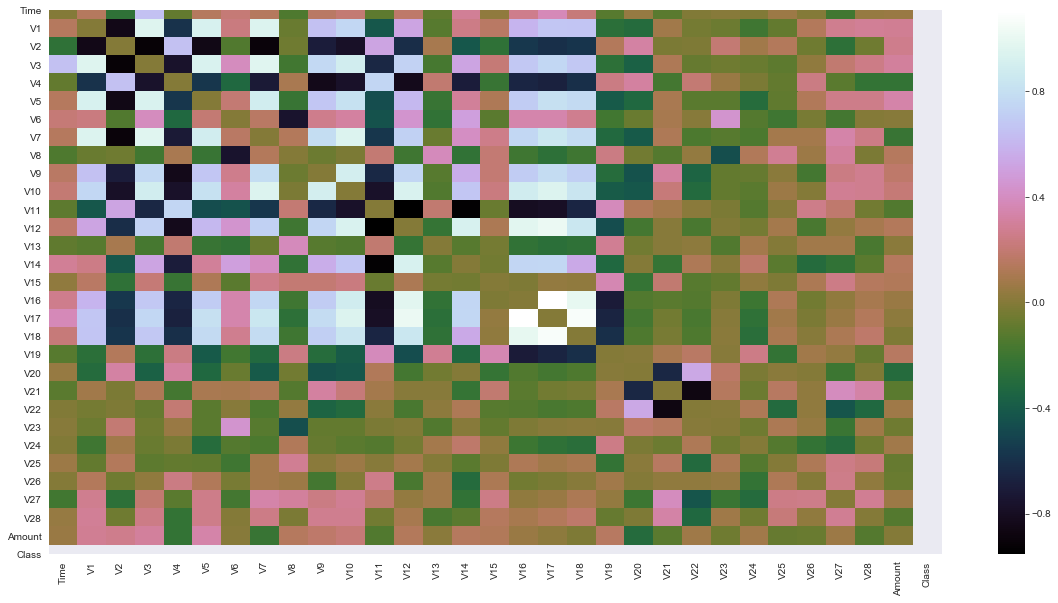

In [567]:
#Identify correlations to make sure there is data the model that can use to predict fraudulent transactions 
plt.figure(figsize = (20,10))
sns.heatmap(trans_df[trans_df['Class'] == 1].corr()-trans_df[trans_df['Class'] == 0].corr(),cmap="cubehelix")

In [568]:
#Made into a function so the train test split set up can be reset for each model
def ttt_setup():
    trans_df = pd.read_csv('creditcard.csv')

    #Robust scaler scales the data according to the quartile range so outliers don not skew the data
    trans_df['scaled_amount'] = RobustScaler().fit_transform(trans_df['Amount'].values.reshape(-1,1))
    trans_df['scaled_time'] = RobustScaler().fit_transform(trans_df['Time'].values.reshape(-1,1))
    trans_df.drop(['Time','Amount'],axis = 1,inplace = True)

    #Create model input and output data
    X = trans_df.drop('Class',axis= 1)
    Y = trans_df['Class']

    #Indicies from random samples to compare to fraudulent transactions
    fraud_indx = trans_df[trans_df['Class'] == 1].index
    non_fraud_indx = trans_df[trans_df['Class'] != 1].index

    #Identify random indexes for fraud and non fraud under sampled dataframes
    random_nonfraud_indx = np.random.choice(non_fraud_indx , fraud , replace = False)
    random_nonfraud_indx = np.array(random_nonfraud_indx)

    #The joining of both 
    under_sample_indx = np.concatenate([fraud_indx,random_nonfraud_indx])

    #Identifying the rows associated with each index
    under_sample_df = trans_df.iloc[under_sample_indx]
    X_under_sample = under_sample_df.drop('Class',axis = 1)
    y_under_sample = under_sample_df['Class']

    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.25)

    X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under_sample,y_under_sample)

In [569]:
#FIRST MODEL: logistic regression
#---------------------------------------------
ttt_setup()

In [570]:
LogReg = LogisticRegression()

In [571]:
LogReg.fit(X_train_under,y_train_under)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [572]:
y_pred_LR = LogReg.predict(X_test_under)

In [573]:
classification_report_LR = sklearn.metrics.classification_report(y_test_under, y_pred_LR,labels=[1])

In [574]:
print(classification_report_LR)

              precision    recall  f1-score   support

           1       0.97      0.84      0.90       132

   micro avg       0.97      0.84      0.90       132
   macro avg       0.97      0.84      0.90       132
weighted avg       0.97      0.84      0.90       132



In [575]:
#SECOND MODEL: Random Forest 
#---------------------------------------------
ttt_setup()

In [576]:
RanFor = RandomForestClassifier()
RanFor.fit(X_train_under,y_train_under)
y_pred_RF = RanFor.predict(X_test_under)

In [577]:
classification_report_RF = sklearn.metrics.classification_report(y_test_under, y_pred_RF,labels=[1])
print(classification_report_RF)

              precision    recall  f1-score   support

           1       0.96      0.80      0.87       132

   micro avg       0.96      0.80      0.87       132
   macro avg       0.96      0.80      0.87       132
weighted avg       0.96      0.80      0.87       132



In [578]:
#THIRD MODEL: Suport Vector machine 
#---------------------------------------------
ttt_setup()

In [579]:
svm = SVC()
svm.fit(X_train_under,y_train_under)
y_pred_svm = svm.predict(X_test_under)

In [580]:
classification_report_svm = sklearn.metrics.classification_report(y_test_under, y_pred_svm,labels=[1])
print(classification_report_svm)

              precision    recall  f1-score   support

           1       0.99      0.80      0.88       132

   micro avg       0.99      0.80      0.88       132
   macro avg       0.99      0.80      0.88       132
weighted avg       0.99      0.80      0.88       132



In [581]:
#FORTH MODEL: Standard Neural Net:
#---------------------------------------------
ttt_setup()

In [582]:
MLPCl = MLPClassifier(hidden_layer_sizes=1000,activation = 'relu',solver = 'adam',max_iter=200)
MLPCl.fit(X_train_under,y_train_under)
y_pred_MLPCl = svm.predict(X_test_under)

In [583]:
classification_report_MLPCl = sklearn.metrics.classification_report(y_test_under, y_pred_MLPCl,labels=[1])
print(classification_report_MLPCl)

              precision    recall  f1-score   support

           1       0.99      0.80      0.88       132

   micro avg       0.99      0.80      0.88       132
   macro avg       0.99      0.80      0.88       132
weighted avg       0.99      0.80      0.88       132



In [584]:
#check to see which model produces the best precision and recall trade off with recall being favoured 
Precision = [classification_report_LR[84:88],classification_report_RF[84:88],classification_report_svm[84:88],classification_report_MLPCl[84:88]]
Precision_int = list(map(float, Precision))
Recall = [classification_report_LR[74:78],classification_report_RF[74:78],classification_report_svm[74:78],classification_report_MLPCl[74:78]]
Recall_int = list(map(float, Recall)) 
PreRec_df = pd.DataFrame({
    'Model': ['LogReg', 'RandFor','SVM','MLP'],
    'Precision': Precision_int,
    'Recall': Recall_int
})

In [585]:
sns.set_style("darkgrid")

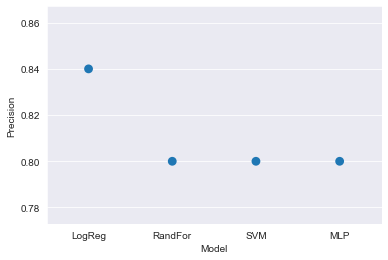

In [586]:
sns.pointplot(x="Model", y="Precision", data = PreRec_df,join = False)

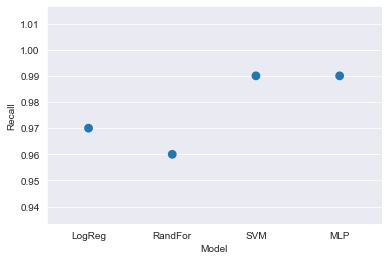

In [587]:
sns.pointplot(x="Model", y="Recall", data = PreRec_df,join = False)